In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 데이터 로드
train = pd.read_csv('../train_chungju_new.csv', encoding='utf-8')
train.columns
test = pd.read_csv('../test_2020.csv', encoding='utf-8')

# 결측치 확인
train.isna().sum()
test.isna().sum()

# train 전처리
train.columns = [col.split('(')[0].strip() for col in train.columns]
train

train.query('일시 == "2017-04-03 22:00"')
train.query('일시 == "2017-04-03 23:00"')
train.query('일시 == "2017-04-04 00:00"')

missing_hour = pd.DataFrame({
    "일시": ["2017-04-03 23:00"],
    "기온": [(13.2 + 11.4) / 2],
    "강수량": [0],
    "풍속": [(1.7 + 0.6) / 2],
    "습도": [(23 + 30) / 2],
    "일조": [0],
    "일사": [0]
})
train = pd.concat([train, missing_hour], ignore_index=True)

train['일시'] = pd.to_datetime(train['일시'])

# '일시' 열을 기준으로 정렬하고 인덱스 재설정
train = train.sort_values(by='일시').reset_index(drop=True)

train['year'] = train['일시'].dt.year
train['month'] = train['일시'].dt.month
train['hour'] = train['일시'].dt.hour

# 결측치 처리
train['일조'] = train['일조'].fillna(0.0)
train['일사'] = train['일사'].fillna(0.0)
train['강수량'] = train['강수량'].fillna(0.0)

train[train['풍속'].isna()] # 20971 번째 행이 문제.
# 날씨는 이어진다. 그 사이 데이터를 보자.
train.iloc[20961: 20981, :] # 그 전 후 1시간동안 2.5였음.

train['풍속'] = train['풍속'].fillna(2.5)

# test 전처리
test.columns = [col.split('(')[0].strip() for col in test.columns]

test['일시'] = pd.to_datetime(test['일시'])
test['year'] = test['일시'].dt.year
test['month'] = test['일시'].dt.month
test['hour'] = test['일시'].dt.hour

## 태양에너지 테스트 데이터
test.isna().sum()
test[test['습도'].isna()] # 673, 674 번째 행이 문제.
# 2020-06-29 1시와 2시에 습도 데이터가 없는 거구나!

# 날씨는 이어진다. 그 사이 데이터를 보자.
test.iloc[672: 676, :] # 2시간 사이에 64.0 에서 82.0으로 바뀌었다!

test.loc[673, '습도'] = 70
test.loc[674, '습도'] = 76

test['일조'] = test['일조'].fillna(0.0)
test['일사'] = test['일사'].fillna(0.0)
test['강수량'] = test['강수량'].fillna(0.0)

train.isna().sum()
test.isna().sum()

# '일시' 열을 인덱스로 설정하여 시간 순서에 따라 정렬
train.set_index('일시', inplace=True)
test.set_index('일시', inplace=True)

##############################
# Feature와 Target 분리
X_train = train.drop(['일사'], axis=1)
y_train = train['일사']
X_test = test.drop(['일사'], axis=1)
y_test = test['일사']


In [2]:
# 모델 학습 및 예측 함수
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, is_lstm=False):
    if is_lstm:
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
        test_predict = model.predict(X_test).flatten()
    else:
        model.fit(X_train, y_train)
        test_predict = model.predict(X_test)
    
    train_predict = model.predict(X_train) if not is_lstm else model.predict(X_train).flatten()
    
    mae_test = mean_absolute_error(y_test, test_predict)
    rmse_test = np.sqrt(mean_squared_error(y_test, test_predict))
    
    print(f"Test - MAE: {mae_test:.5f}, RMSE: {rmse_test:.5f}")
    return test_predict

# LightGBM Regressor
print("\nLightGBM Regressor Results")
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42)
lgbm_pred = train_and_evaluate_model(lgbm_model, X_train, y_train, X_test, y_test)



LightGBM Regressor Results
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 29928, number of used features: 8
[LightGBM] [Info] Start training from score 0.612957
Test - MAE: 0.09005, RMSE: 0.15402


c:\DS\miniconda3\envs\mychat\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\DS\miniconda3\envs\mychat\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


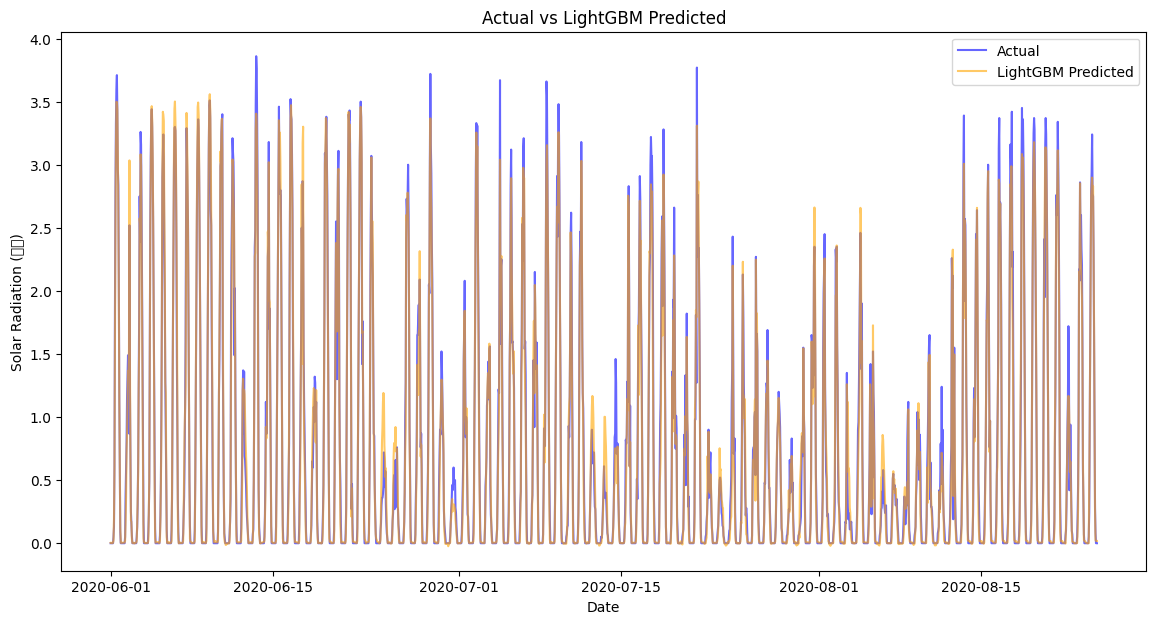

In [3]:
# 예측값과 실제값 비교 시각화
train.reset_index(inplace=True)
test.reset_index(inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(test['일시'], y_test, label='Actual', color='blue', alpha=0.6)
plt.plot(test['일시'], lgbm_pred, label='LightGBM Predicted', color='orange', alpha=0.6)
plt.title('Actual vs LightGBM Predicted')
plt.xlabel('Date')
plt.ylabel('Solar Radiation (일사)')
plt.legend()
plt.show()

# 실습데이터에 일사량 추가

In [4]:
df = pd.read_csv('../data_week2.csv',encoding='euc-kr')
df.columns
df.columns = [col.split('(')[0].strip() for col in df.columns]
df.rename(columns={'date_time': '일시'}, inplace=True)

df['일시'] = pd.to_datetime(df['일시'])
df['year'] = df['일시'].dt.year
df['month'] = df['일시'].dt.month
df['hour'] = df['일시'].dt.hour

df.set_index('일시', inplace=True)
X_df = df[['기온', '강수량', '풍속', '습도', '일조', 'year', 'month', 'hour']]
y_pred = np.round(lgbm_model.predict(X_df), 2)
y_pred
df['예측일사'] = y_pred
df.reset_index(inplace=True)

In [5]:
df.rename(columns={'예측일사': '예측일사_MJ', '전력사용량': '전력사용량_kWh'}, inplace=True)

df['일자'] = df['일시'].dt.date
solar_sum_day = df.groupby(['num','일자'],as_index=False).agg(일일_전력_사용량_kWh=('전력사용량_kWh','sum'),일일_일사량_MJ=('예측일사_MJ','sum'))
MJ_to_kWh = 0.277778
solar_sum_day['일일_일사량_kWh'] = solar_sum_day['일일_일사량_MJ']*MJ_to_kWh
solar_sum_day['일자'] = pd.to_datetime(solar_sum_day['일자'])
solar_sum_day['month'] = solar_sum_day['일자'].dt.month
solar_sum_day


,num,일자,일일_전력_사용량_kWh,일일_일사량_MJ,일일_일사량_kWh,month
0,1,2020-06-01,193194.720,27.53,7.647228,6
1,1,2020-06-02,190996.056,8.80,2.444446,6
2,1,2020-06-03,198470.736,24.27,6.741672,6
3,1,2020-06-04,203033.952,18.67,5.186115,6
4,1,2020-06-05,206675.064,24.54,6.816672,6
...,...,...,...,...,...,...
5095,60,2020-08-20,90000.288,20.13,5.591671,8
5096,60,2020-08-21,88511.184,16.85,4.680559,8
5097,60,2020-08-22,84975.264,12.19,3.386114,8
5098,60,2020-08-23,83065.824,24.15,6.708339,8


In [6]:
solar_sum_month = solar_sum_day.groupby(['num','month'],as_index=False).agg(월별_전력_사용량_kWh=('일일_전력_사용량_kWh','sum'),월별_일사량_kWh = ('일일_일사량_kWh','sum'))
solar_sum_month['월별_전력_사용량_kWh'] = np.round(solar_sum_month['월별_전력_사용량_kWh'],3)
solar_sum_month

,num,month,월별_전력_사용량_kWh,월별_일사량_kWh
0,1,6,6126308.640,171.027915
1,1,7,6326572.392,122.405653
2,1,8,4975396.884,63.713940
3,2,6,916776.792,169.519580
4,2,7,950308.524,98.147301
...,...,...,...,...
175,59,7,748393.234,102.919527
176,59,8,752053.420,109.016754
177,60,6,2292740.640,173.366805
178,60,7,2463337.318,139.166778


In [7]:
solar_sum_month.query('month == 7').sort_values('월별_전력_사용량_kWh',ascending=False).head()


,num,month,월별_전력_사용량_kWh,월별_일사량_kWh
22,8,7,6570431.550,107.638975
1,1,7,6326572.392,122.405653
112,38,7,5537480.760,122.405653
160,54,7,5191946.424,129.622326
91,31,7,4402301.184,122.405653


In [8]:
solar_sum_month.query('month == 7').sort_values('월별_전력_사용량_kWh',ascending=False).tail()

,num,month,월별_전력_사용량_kWh,월별_일사량_kWh
85,29,7,615117.564,105.358418
55,19,7,563484.438,98.147301
10,4,7,553317.744,110.663977
166,56,7,499995.828,111.413978
79,27,7,480902.670,116.561204


In [9]:
solar_sum_total = solar_sum_day.groupby(['num'],as_index=False).agg(총_전력_사용량_kWh = ('일일_전력_사용량_kWh','sum'),총_일사량_kWh = ('일일_일사량_kWh','sum'))
solar_sum_total['총_전력_사용량_kWh'] = np.round(solar_sum_total['총_전력_사용량_kWh'],3)
solar_sum_total

,num,총_전력_사용량_kWh,총_일사량_kWh
0,1,1.742828e+07,357.147508
1,2,2.651825e+06,381.069749
2,3,6.877562e+06,380.969749
3,4,1.558555e+06,410.605884
4,5,5.537600e+06,381.069749
5,6,2.415625e+06,380.969749
6,7,3.115362e+06,357.147508
7,8,1.802822e+07,373.686410
8,9,2.564045e+06,374.389188
9,10,2.911415e+06,381.069749


In [10]:
is_solar = df.groupby(['num'],as_index=False).agg(태양광보유=('태양광보유','sum'))
is_solar['태양광보유'] = is_solar['태양광보유'].apply(lambda x: 1 if x > 0 else 0)
solar_sum_total = solar_sum_total.merge(is_solar, on='num', how='left').sort_values('총_일사량_kWh',ascending=False).reset_index(drop=True)
solar_sum_total.head(10)


,num,총_전력_사용량_kWh,총_일사량_kWh,태양광보유
0,29,1756591.466,413.511442,0
1,4,1558554.601,410.605884,1
2,60,6843734.806,393.280870,1
3,42,7394167.735,393.280870,1
4,35,2651912.143,393.280870,0
5,48,2331727.073,393.280870,0
6,12,3567660.810,393.280870,1
7,26,6094884.900,391.239202,1
8,37,4064728.885,390.339201,1
9,43,3750605.856,387.805866,1


In [11]:
solar_sum_total['총_일사량_kWh'].max() - solar_sum_total['총_일사량_kWh'].min()


65.74727482000003

<Axes: ylabel='총_일사량_kWh'>

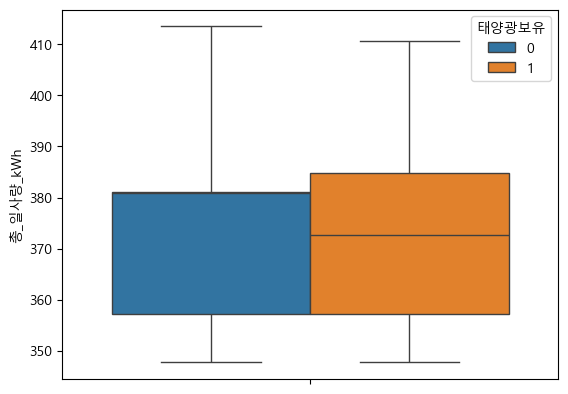

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') 
sns.boxplot(data=solar_sum_total, y='총_일사량_kWh', hue='태양광보유')

<Axes: ylabel='총_일사량_kWh'>

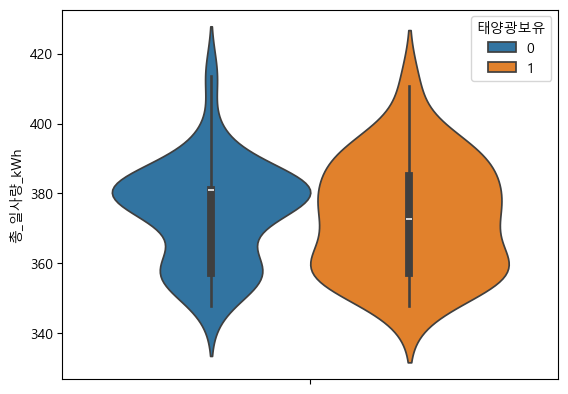

In [20]:
sns.violinplot(data=solar_sum_total, y='총_일사량_kWh', hue='태양광보유')

<Axes: xlabel='num', ylabel='총_일사량_kWh'>

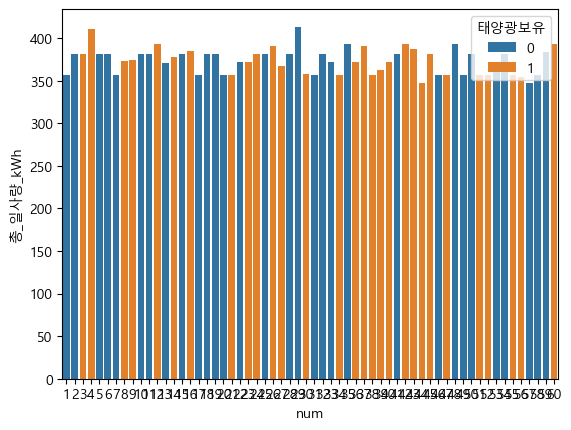

In [21]:
sns.barplot(data=solar_sum_total, x='num', y='총_일사량_kWh', hue='태양광보유')


<Axes: xlabel='총_일사량_kWh', ylabel='Count'>

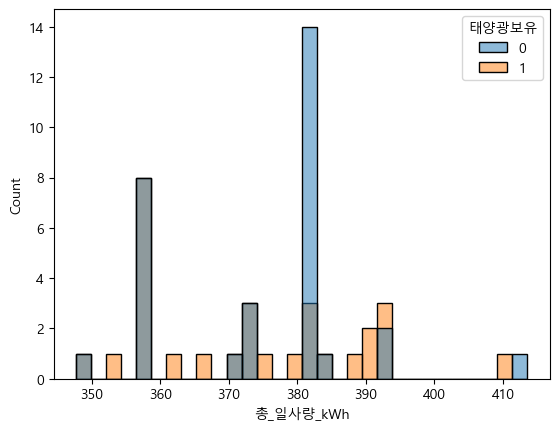

In [22]:
sns.histplot(data=solar_sum_total, x='총_일사량_kWh', bins=30, hue='태양광보유')


<Axes: xlabel='총_일사량_kWh', ylabel='Density'>

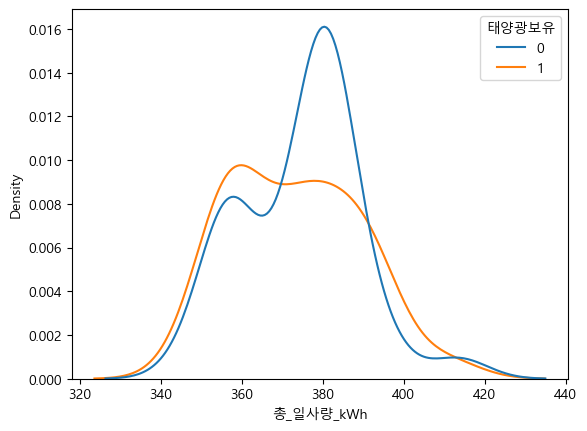

In [23]:
sns.kdeplot(data=solar_sum_total, x='총_일사량_kWh', hue='태양광보유')


# 기상청 데이터 시각화

<Axes: xlabel='time_of_day', ylabel='count'>

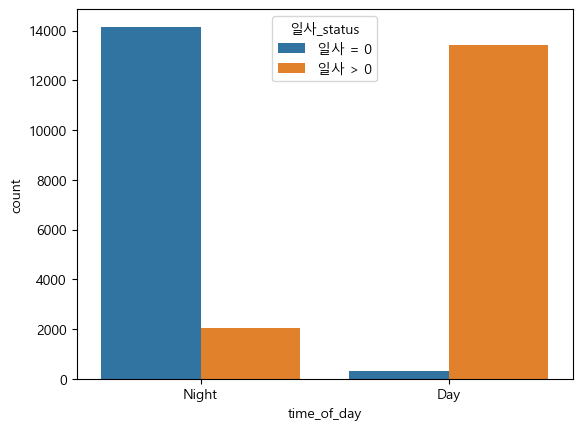

In [24]:
train['time_of_day'] = train['hour'].apply(lambda x: 'Day' if 8 <= x <= 18 else 'Night')

# 일사가 0인 경우와 0 초과인 경우를 구분하는 열 추가
train['일사_status'] = train['일사'].apply(lambda x: '일사 > 0' if x > 0 else '일사 = 0')

import seaborn as sns
plt.rc('font', family='Malgun Gothic') 
sns.countplot(data=train, x='time_of_day', hue='일사_status')


In [25]:
result = train.query('일사 > 0').groupby('month', as_index=False).agg(
    min_hour=('hour', 'min'),
    max_hour=('hour', 'max')
)

result

,month,min_hour,max_hour
0,1,8,18
1,2,8,19
2,3,7,19
3,4,6,20
4,5,6,20
5,6,6,20
6,7,6,20
7,8,6,20
8,9,7,19
9,10,7,19


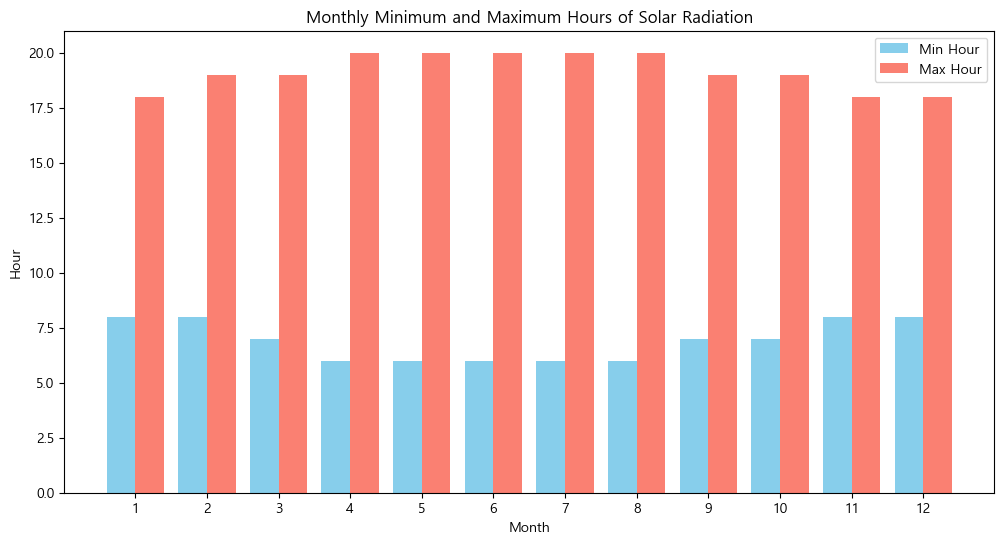

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(result['month'] - 0.2, result['min_hour'], width=0.4, label='Min Hour', color='skyblue')
plt.bar(result['month'] + 0.2, result['max_hour'], width=0.4, label='Max Hour', color='salmon')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.title('Monthly Minimum and Maximum Hours of Solar Radiation')
plt.xticks(result['month'])
plt.legend()
plt.show()

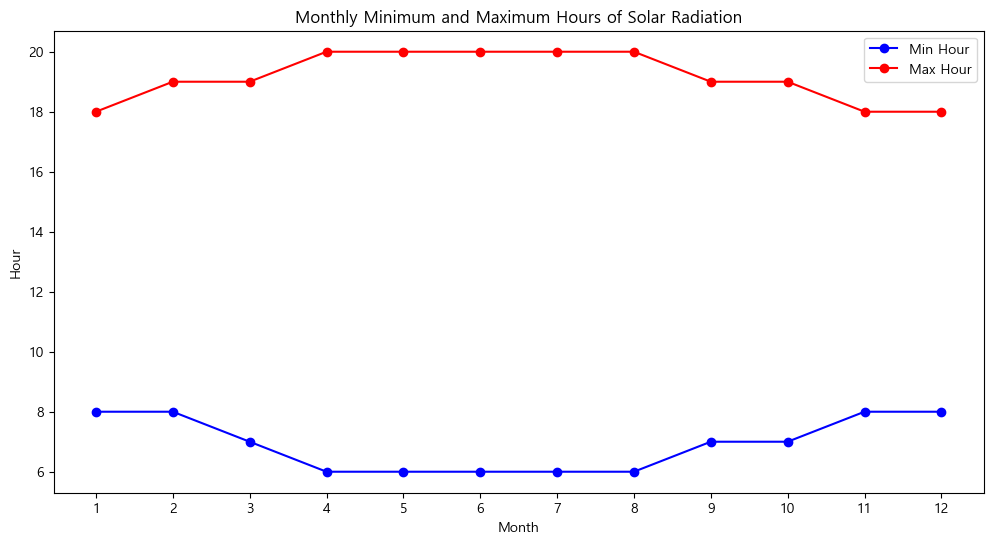

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(result['month'], result['min_hour'], marker='o', label='Min Hour', color='blue')
plt.plot(result['month'], result['max_hour'], marker='o', label='Max Hour', color='red')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.title('Monthly Minimum and Maximum Hours of Solar Radiation')
plt.xticks(result['month'])
plt.legend()
plt.show()

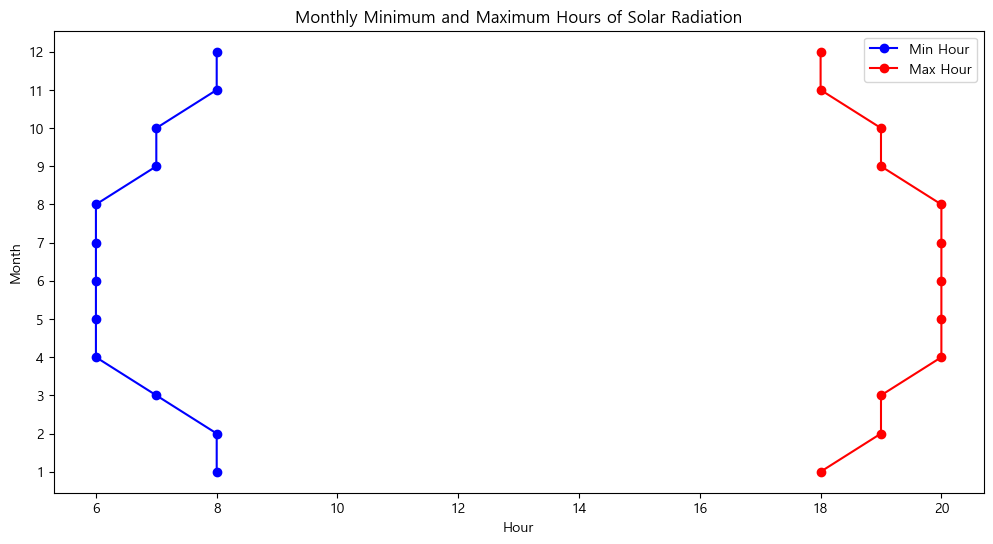

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(result['min_hour'], result['month'], marker='o', label='Min Hour', color='blue')
plt.plot(result['max_hour'], result['month'], marker='o', label='Max Hour', color='red')
plt.ylabel('Month')
plt.xlabel('Hour')
plt.title('Monthly Minimum and Maximum Hours of Solar Radiation')
plt.yticks(result['month'])
plt.legend()
plt.show()

In [35]:

# 한화 큐셀 600W 태양관 모듈 * 160개 (1억 든다고 함) (실제 공장도 이렇게 600w 160개 하더라) 
# (청주 공장이라고 가정, 전기 사용량 개많아서)

# 발전 효율 : 21.5% 
# 설치 면적 : 2.462 * 1.134 = 2.791908

solar_sum_total.head(10)

,num,총_전력_사용량_kWh,총_일사량_kWh,태양광보유
0,29,1756591.466,413.511442,0
1,4,1558554.601,410.605884,1
2,60,6843734.806,393.280870,1
3,42,7394167.735,393.280870,1
4,35,2651912.143,393.280870,0
5,48,2331727.073,393.280870,0
6,12,3567660.810,393.280870,1
7,26,6094884.900,391.239202,1
8,37,4064728.885,390.339201,1
9,43,3750605.856,387.805866,1


In [39]:
efficiency = 0.215
area = 2.462 * 1.134 
num = 160

solar_sum_total['예상_발전량_kWh']  = solar_sum_total['총_일사량_kWh'] * area * num * efficiency
solar_sum_total.head(10)

,num,총_전력_사용량_kWh,총_일사량_kWh,태양광보유,예상_발전량_kWh
0,29,1756591.466,413.511442,0,39714.315056
1,4,1558554.601,410.605884,1,39435.260526
2,60,6843734.806,393.280870,1,37771.337865
3,42,7394167.735,393.280870,1,37771.337865
4,35,2651912.143,393.280870,0,37771.337865
5,48,2331727.073,393.280870,0,37771.337865
6,12,3567660.810,393.280870,1,37771.337865
7,26,6094884.900,391.239202,1,37575.252703
8,37,4064728.885,390.339201,1,37488.815162
9,43,3750605.856,387.805866,1,37245.509492


In [37]:
solar_sum_total.query('태양광보유 == 0').head(3)

,num,총_전력_사용량_kWh,총_일사량_kWh,태양광보유,예상_발전량_kWh
0,29,1756591.466,413.511442,0,39714.315056
4,35,2651912.143,393.280870,0,37771.337865
5,48,2331727.073,393.280870,0,37771.337865
